In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals10/translate.py
/kaggle/input/animals10/raw-img/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-TPYKs3XId_sMgp_6LLA6JgDMEy.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-jlVRrokx7Vu1axi8OnTX2AHaE2.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-F4QVZ71QagiynDMnFNxJUAHaEK.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-UFtUZnXq0JHZo5R8UuF80wHaFj.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-irWuWeIWd3Hm3BWGd0OEsQHaGO.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-Y-hB14A3coI7TEgrEew0UAHaFj.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-KqeKmYfnRwKd89nLg8_zRAHaHb.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-s40xdXSQY099gt1hLGlzAwHaFP.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-4k_sWoJ4_9-G1f0emDBVtwHaE6.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-W-uUxHx-yovp1DQNtX1qdQHaFk.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-Npxx8kemjjTljUyT9-BQgAHaFi.jpeg
/kaggle/input/animals10/raw-img/cavallo/OIP-jCu7nlv

# Step 1: Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define the translation dictionary
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

# Step 2: Set Parameters

In [4]:
# Define the batch size for training. It specifies the number of images to process in each training batch.
batch_size = 32

# Define the image size. This is the size to which all input images will be resized.
img_size = 224

# Define the directory where your image dataset is located. 
# Change this path to the directory containing your dataset.
directory = '/kaggle/input/animals10/raw-img'

# Step 3: Create Image Data Generators

In [5]:
# Create an ImageDataGenerator object to preprocess and augment the image data.
datagen = ImageDataGenerator(
    rescale=1/255.,             # Rescale pixel values to a range of [0, 1]
    zoom_range=0.2,             # Randomly zooming images by up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    validation_split=0.15       # Split the data into training and validation sets (85% for training)
)

# Step 4: Create Data Generators for Training and Validation

In [6]:
# Create a data generator for the training set
train_generator = datagen.flow_from_directory(
    directory,                             # The directory where the image data is located
    target_size=(img_size, img_size),      # The target size to which all images will be resized
    batch_size=batch_size,                 # The batch size for training data
    shuffle=True,                          # Shuffle the training data for randomness
    subset='training',                     # Specify that this is the training subset
    class_mode='categorical'               # The class mode for categorical classification
)

# Create a data generator for the validation set
validation_generator = datagen.flow_from_directory(
    directory,                             # The same directory as the training data
    target_size=(img_size, img_size),      # The same target size as for training
    batch_size=batch_size,                 # The same batch size as for training
    shuffle=False,                         # Do not shuffle the validation data
    subset='validation',                   # Specify that this is the validation subset
    class_mode='categorical'               # The same class mode as for training
)

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


# Step 5: Prepare Labels and Display Sample Images

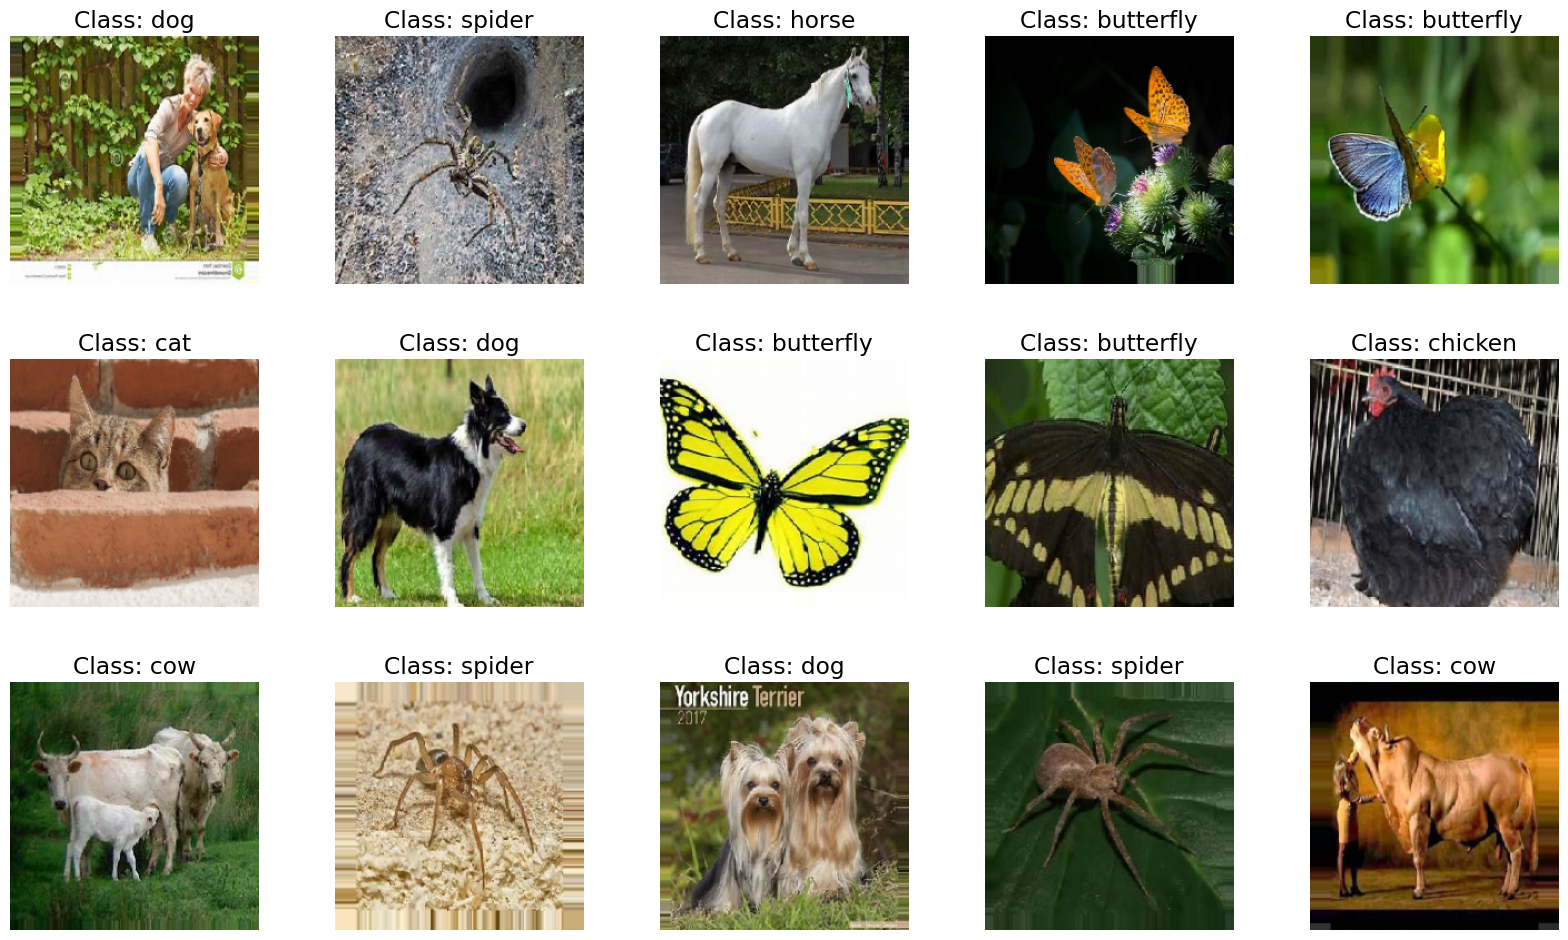

In [7]:
# Load the translated class names for printing
labels = [k for k in train_generator.class_indices]
translated_labels = [translate[label] for label in labels]

# Get the class labels from the data generator
labels = [k for k in train_generator.class_indices]

# Generate a batch of data for display
sample_generate = train_generator.__next__()

# Extract the images and their corresponding titles (class labels)
images = sample_generate[0]
titles = sample_generate[1]

# Create a figure to display the sample images
plt.figure(figsize=(20, 20))

# Loop through and display 15 sample images
for i in range(15):
    # Create subplots in a grid of 5x5
    plt.subplot(5, 5, i+1)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # Display the image
    plt.imshow(images[i])
    
    # Set the title of the subplot to the corresponding class label
    # Use np.argmax to find the index of the class with the highest probability
    plt.title(f'Class: {translated_labels[np.argmax(titles[i], axis=0)]}')
    
    # Turn off axis labels for cleaner visualization
    plt.axis("off")

# Show the figure with the sample images and their labels
plt.show()

# Step 6: Load the Pretrained VGG16 Model

In [8]:
# Define the input image size (224x224 pixels)
img_size = 224

# Load the VGG16 model with specific configurations
base_model = VGG16(include_top=False,  # Exclude the fully connected layers at the top
                  weights='imagenet',  # Initialize the model with pretrained ImageNet weights
                  input_shape=(img_size, img_size, 3))  # Input shape: 224x224 pixels with 3 color channels (RGB)

# Display a summary of the base model architecture
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Step 7: Freeze the Bottom Layers of the Model

In [9]:
# Freezing layers means making them non-trainable, so their weights won't be updated during training.

# Loop through all layers in the base_model except the last 4 layers and set them as non-trainable.
# This allows us to retain the feature extraction capabilities of the pretrained model while customizing the top layers.
for layer in base_model.layers[:-4]:
    layer.trainable = False

# After this loop, the layers in the base_model from the input up to the fourth-to-last layer will remain non-trainable.
# Only the last 4 layers (typically fully connected layers) will be trainable for fine-tuning.
# This is a common strategy in transfer learning to adapt a pretrained model to a specific task while preserving its learned features.
# It helps prevent overfitting when you have limited data for your specific task.

# Step 8: Define Model Callbacks

In [10]:
# Define a name for the model checkpoint file
model_name = 'model.h5'

# Create a ModelCheckpoint callback
# - `monitor='val_loss'`: Monitor the validation loss during training.
# - `mode='min'`: Save the model when the monitored quantity (validation loss) is minimized.
# - `save_best_only=True`: Only save the model when the validation loss improves.
# - `verbose=1`: Display progress information.
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',  # Monitor validation loss
                            mode='min',          # Save when validation loss is minimized
                            save_best_only=True, # Save only the best model
                            verbose=1)           # Display progress

# Create an EarlyStopping callback
# - `monitor='val_loss'`: Monitor the validation loss during training.
# - `min_delta=0`: Minimum change in validation loss to be considered an improvement.
# - `patience=5`: Number of epochs with no improvement after which training will stop.
# - `verbose=1`: Display progress information.
# - `restore_best_weights=True`: Restore model weights to the best recorded epoch when training stops.
earlystopping = EarlyStopping(monitor='val_loss',      # Monitor validation loss
                             min_delta=0,            # Minimum improvement in loss
                             patience=5,             # Number of epochs with no improvement
                             verbose=1,              # Display progress
                             restore_best_weights=True) # Restore best weights

# These callbacks are used during model training to save the best model and stop early if no improvement is observed.

# Step 9: Build and Compile the Custom Model

In [11]:
# Get the output from the pretrained VGG16 base model
last_output = base_model.output

# Add a Global Average Pooling 2D layer to reduce the spatial dimensions of the feature maps
x = GlobalAveragePooling2D()(last_output)

# Add a Dense layer with 512 units and ReLU activation function
x = Dense(512, activation='relu')(x)

# Add the final Dense layer with 10 units (assuming it's a 10-class classification task) and softmax activation function
outputs = Dense(10, activation='softmax')(x)

# Create the custom model by specifying the input (base_model.inputs) and output (outputs)
model = Model(inputs=base_model.inputs, outputs=outputs)

# Compile the model with the Adam optimizer and categorical cross-entropy loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# The custom model is now built and compiled, ready for training.

# Step 10: Train the Model

In [ ]:
# Fit the custom model to the training data using the data generator.
# The training runs for a specified number of epochs (in this case, 3).
# The validation data is used to monitor the model's performance during training.
# Callbacks are used to save the best model checkpoint and implement early stopping.

history = model.fit(
    train_generator,                      # Training data generator
    epochs=3,                             # Number of training epochs
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, earlystopping]  # List of callbacks for monitoring and saving
)

# After training is complete, you can analyze the training history to understand
# how the model's performance evolved during training.

### 10.1 Visualize model loss and accuracy

In [15]:
# Plot the training and validation loss over epochs.
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# These plots provide insights into the model's convergence and performance on
# both the training and validation datasets.

NameError: name 'history' is not defined

<Figure size 2000x800 with 0 Axes>

# Step 11: Visualize Model Loss and Accuracy

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a figure with a specified size for loss visualization
plt.figure(figsize=(20, 8))

# Plot the training loss curve
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss curve
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title of the plot
plt.title('Model Loss')

# Label the y-axis
plt.ylabel('Loss')

# Label the x-axis
plt.xlabel('Epoch')

# Add a legend to the plot to distinguish training and validation curves
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the loss curve plot as an image
plt.savefig('loss_curve.png')

# Display the loss curve plot
plt.show()

# Create another figure with a specified size for accuracy visualization
plt.figure(figsize=(20, 8))

# Plot the training accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy curve
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Set the title of the plot
plt.title('Model Accuracy')

# Label the y-axis
plt.ylabel('Accuracy')

# Label the x-axis
plt.xlabel('Epoch')

# Add a legend to the plot to distinguish training and validation curves
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the accuracy curve plot as an image
plt.savefig('accuracy_curve.png')

# Display the accuracy curve plot
plt.show()

NameError: name 'history' is not defined

<Figure size 2000x800 with 0 Axes>

# Step 12: Evaluate the Model

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Load the best saved model
model = tf.keras.models.load_model('/kaggle/input/my-model/my_model.h5')

# Get the true labels for the validation data
y_test = validation_generator.classes

# Make predictions on the validation data
y_pred = model.predict(validation_generator)

# Make a copy of prediction probabilities for later use
y_pred_probs = y_pred.copy()

# Convert predicted probabilities to integer class labels
y_pred_int = np.argmax(y_pred_probs, axis=1)

# Define the translation dictionary
translate = {
    0: "dog",
    1: "horse",
    2: "elephant",
    3: "butterfly",
    4: "chicken",
    5: "cat",
    6: "cow",
    7: "sheep",
    8: "spider",
    9: "squirrel",
}

# Translate class labels using the dictionary
y_test_translated = [translate[label] for label in y_test]
y_pred_translated = [translate[label] for label in y_pred_int]

# Print a classification report with translated class names
# The classification report provides precision, recall, F1-score, and support for each class.
# It helps evaluate the model's performance on each class.
print(classification_report(y_test_translated, y_pred_translated, target_names=translate.values()))

123/123 [==============================] - 89s 610ms/step
              precision    recall  f1-score   support

         dog       0.96      0.92      0.94       316
       horse       0.91      0.90      0.91       250
    elephant       0.91      0.96      0.94       464
   butterfly       0.94      0.78      0.85       279
     chicken       0.94      0.86      0.90       729
         cat       0.97      0.85      0.91       216
         cow       0.90      0.92      0.91       393
       sheep       0.71      0.92      0.80       273
      spider       0.94      0.99      0.97       723
    squirrel       0.87      0.87      0.87       279

    accuracy                           0.91      3922
   macro avg       0.91      0.90      0.90      3922
weighted avg       0.91      0.91      0.91      3922



# Step 13: Visualize Confusion Matrix

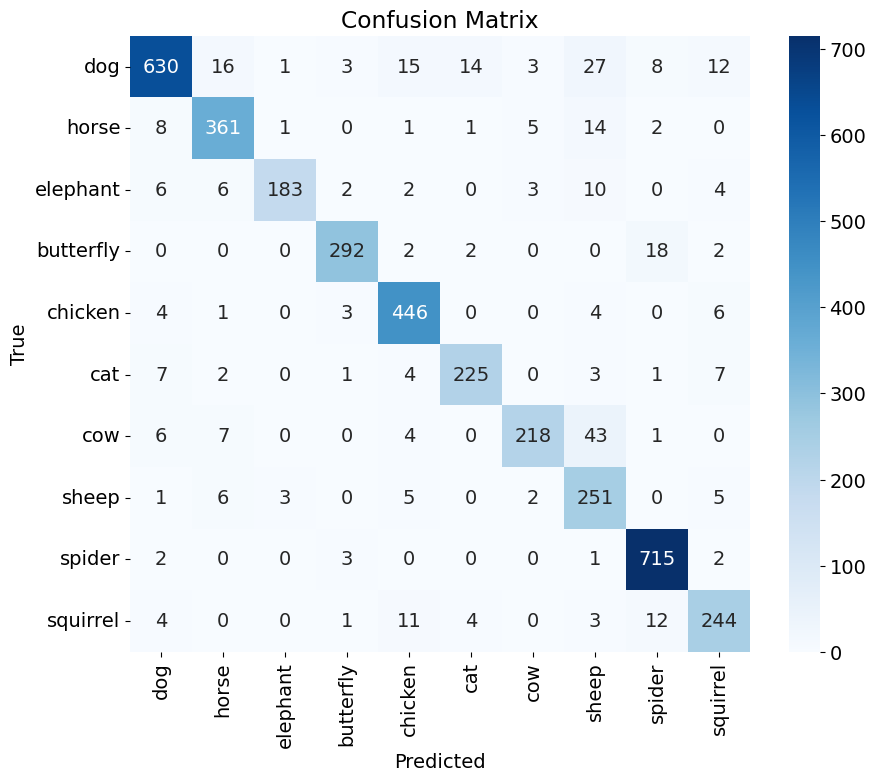

In [17]:
# Calculate the confusion matrix using the true labels (y_test_translated) and predicted labels (y_pred_translated)
confusion_mat = confusion_matrix(y_test_translated, y_pred_translated, labels=list(translate.values()))

# Create a figure for the heatmap with a specified size
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=list(translate.values()), yticklabels=list(translate.values()))

# Add labels to the x and y axes of the heatmap
plt.xlabel('Predicted')  # Label for the x-axis
plt.ylabel('True')       # Label for the y-axis

# Set the title for the heatmap
plt.title('Confusion Matrix')

# Display the confusion matrix heatmap
plt.savefig('confusion_matrix.png')

# Display the confusion matrix heatmap
plt.show()

# Step 14: Print Accuracy, Precision, and Recall

Accuracy: 0.9089750127485976
Precision: 0.9145718391636177
Recall: 0.9089750127485976


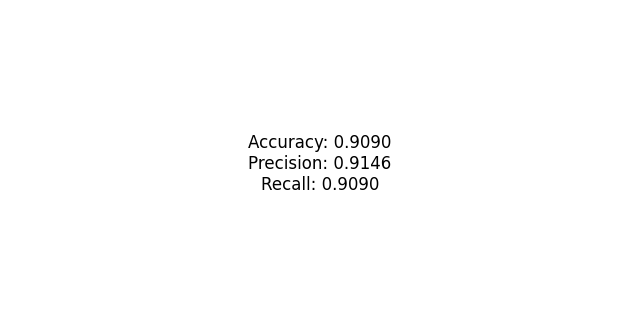

In [18]:
# Import necessary metrics functions from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_int)

# Calculate the weighted precision score (averaging precision for all classes with weight)
precision = precision_score(y_test, y_pred_int, average='weighted')

# Calculate the weighted recall score (averaging recall for all classes with weight)
recall = recall_score(y_test, y_pred_int, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Add the text with metrics to the plot
text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}"
ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, color='black')

# Remove axis labels and ticks
ax.axis('off')

# Save the figure as an image
plt.savefig('Accuracy, Precision, and Recall.png', bbox_inches='tight', dpi=300)

# Step 15: Save the Trained Model

In [ ]:
# After training your model, it's a good practice to save it so you can use it later for inference or further training.
# We save the model with the name 'my_model.h5', but you can choose a different name if desired.
model.save('my_model.h5')